In [1]:
from obspy import read, read_inventory
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# Parameters
T = 21.8       # Pendulum natural period (seconds)
T1 = 24.5      # Galvanometer natural period (seconds)
l = 123.8      # Pendulum length (cm)
mu = 0.2       # Damping coefficient
A1 = 1040      # Static magnification
k = 38         # Coupling coefficient

# Create period array (log scale)
Tp = np.logspace(-1, 2, num=200)  # 0.1 to 100 seconds

# Calculate amplitude response using your formula
ym = 1.0
u = Tp / float(T)
u1 = Tp / T1
fu = (2.*u/(1.+u**2))**2
C1 = np.pi * l / (k*A1)
xm = C1 * ym/Tp * (1.+u**2) * (1.+u1**2) * np.sqrt(1.-fu*mu**2)
amplitude = 1./xm

# Calculate frequency and angular frequency for phase calculation
f = 1 / Tp
omega = 2 * np.pi * f

In [3]:
# Now let's create a function to apply this response to seismic data
def apply_galitzin_response(displacement_data, sampling_rate, T=21.8, T1=24.5, l=123.8, mu=0.2, A1=1040, k=38):
    """
    Apply Galitzin response to ground displacement data using the exact response function
    
    Parameters:
    - displacement_data: Ground displacement time series
    - sampling_rate: Sampling rate in Hz
    - T, T1, l, mu, A1, k: Galitzin parameters
    
    Returns:
    - Simulated Galitzin trace
    """
    # Calculate frequency response at Nyquist-appropriate resolution
    nyquist = sampling_rate / 2
    n_freqs = len(displacement_data) // 2 + 1
    freqs = np.linspace(0, nyquist, n_freqs)
    periods = np.ones_like(freqs)
    # Avoid division by zero at DC
    periods[1:] = 1.0 / freqs[1:]
    
    # Calculate Galitzin response using your formula
    u = periods / float(T)
    u1 = periods / T1
    fu = (2.*u/(1.+u**2))**2
    C1 = np.pi * l / (k*A1)
    xm = C1 * ym/periods * (1.+u**2) * (1.+u1**2) * np.sqrt(1.-fu*mu**2)
    amplitude = 1./xm
    
    # Calculate phase response
    phase = calculate_phase(u, u1, mu)
    phase_rad = phase * np.pi / 180
    
    # Create complex frequency response (amplitude and phase)
    response = amplitude * np.exp(1j * phase_rad)
    
    # Handle DC component (set to near zero)
    response[0] = 1e-10
    
    # Apply response in frequency domain
    data_fft = np.fft.rfft(displacement_data)
    data_fft_filtered = data_fft * response
    
    # Transform back to time domain
    galitzin_trace = np.fft.irfft(data_fft_filtered, n=len(displacement_data))
    
    return galitzin_trace

In [4]:
# Now let's calculate the phase response
# For Galitzin seismograph, phase shift depends on period ratios
# This is a simplified approximation based on theoretical considerations
def calculate_phase(u, u1, mu):
    """Calculate phase response based on period ratios"""
    # Base phase contribution from pendulum (90° at resonance, approaching 180° at high frequencies)
    pendulum_phase = np.arctan2(2*mu*u, 1-u**2)
    
    # Galvanometer contribution (similar behavior)
    galvanometer_phase = np.arctan2(2*0.5*u1, 1-u1**2)  # Assuming damping of 0.5 for galvanometer
    
    # Additional 90° for electromagnetic coupling
    coupling_phase = np.pi/2
    
    # Total phase is the sum, converted to degrees
    total_phase = (pendulum_phase + galvanometer_phase + coupling_phase) * 180/np.pi
    
    # Adjust phase to be within -180 to 180 range
    total_phase = np.mod(total_phase + 180, 360) - 180
    
    return total_phase

phase = calculate_phase(u, u1, mu)

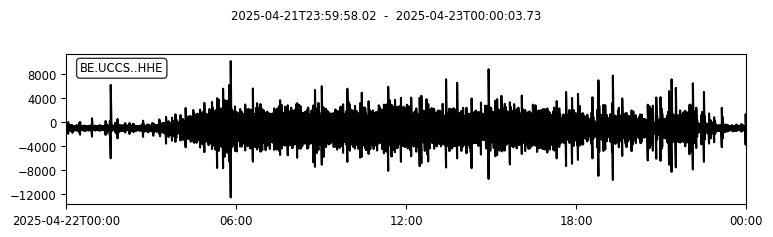

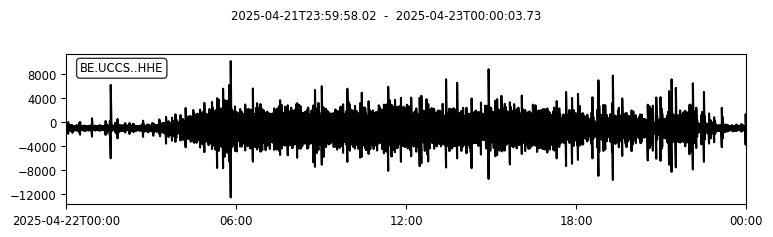

In [5]:
# Load and plot horizontal UCC data
tr = read('waveforms/BE.UCCS..HHE__20250422T000000Z__20250423T000000Z.mseed')[0]
tr.plot()

In [6]:
# Correct instrumental response
inv = read_inventory('stations/BE.UCCS.xml')
# Decimate the sampling rate down to 50 Hz
tr.decimate(2)

BE.UCCS..HHE | 2025-04-21T23:59:58.020000Z - 2025-04-23T00:00:03.720000Z | 50.0 Hz, 4320286 samples

BE.UCCS..HHE | 2025-04-21T23:59:58.020000Z - 2025-04-23T00:00:03.720000Z | 50.0 Hz, 4320286 samples

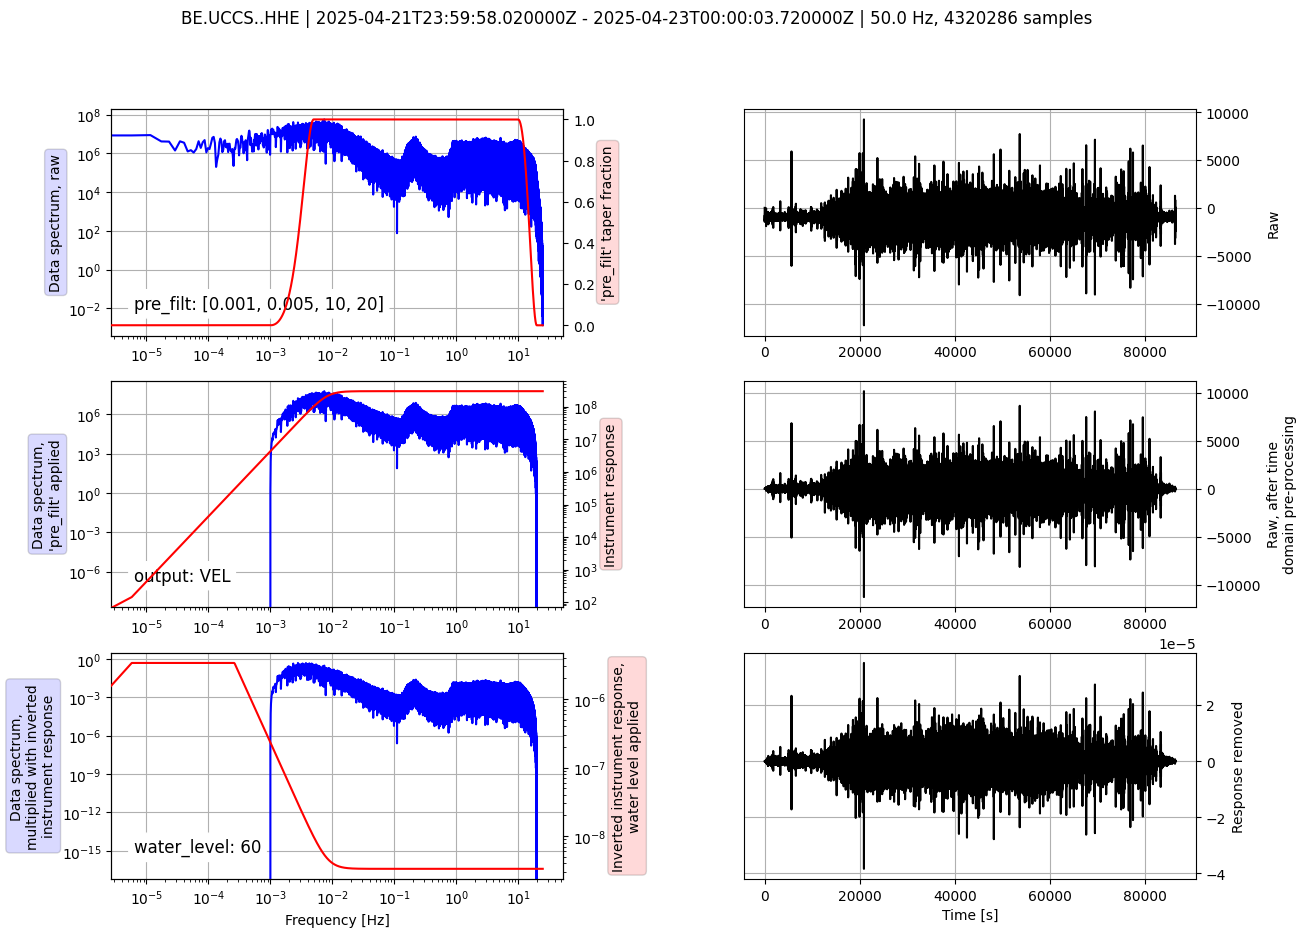

In [7]:
# Remove the sintrumental response
pre_filt = [0.001, 0.005, 10, 20]
tr.remove_response(inventory=inv, pre_filt=pre_filt, output="VEL",
                   water_level=60, plot=True)

In [8]:
# Apply the Galitzin response
galitzin_trace = apply_galitzin_response(tr.data, tr.stats.sampling_rate)

In [9]:
print(len(tr.times()))
print(len(galitzin_trace), type(galitzin_trace), galitzin_trace.shape)
print(tr.stats.sampling_rate)

4320286
4320286 <class 'numpy.ndarray'> (4320286,)
50.0


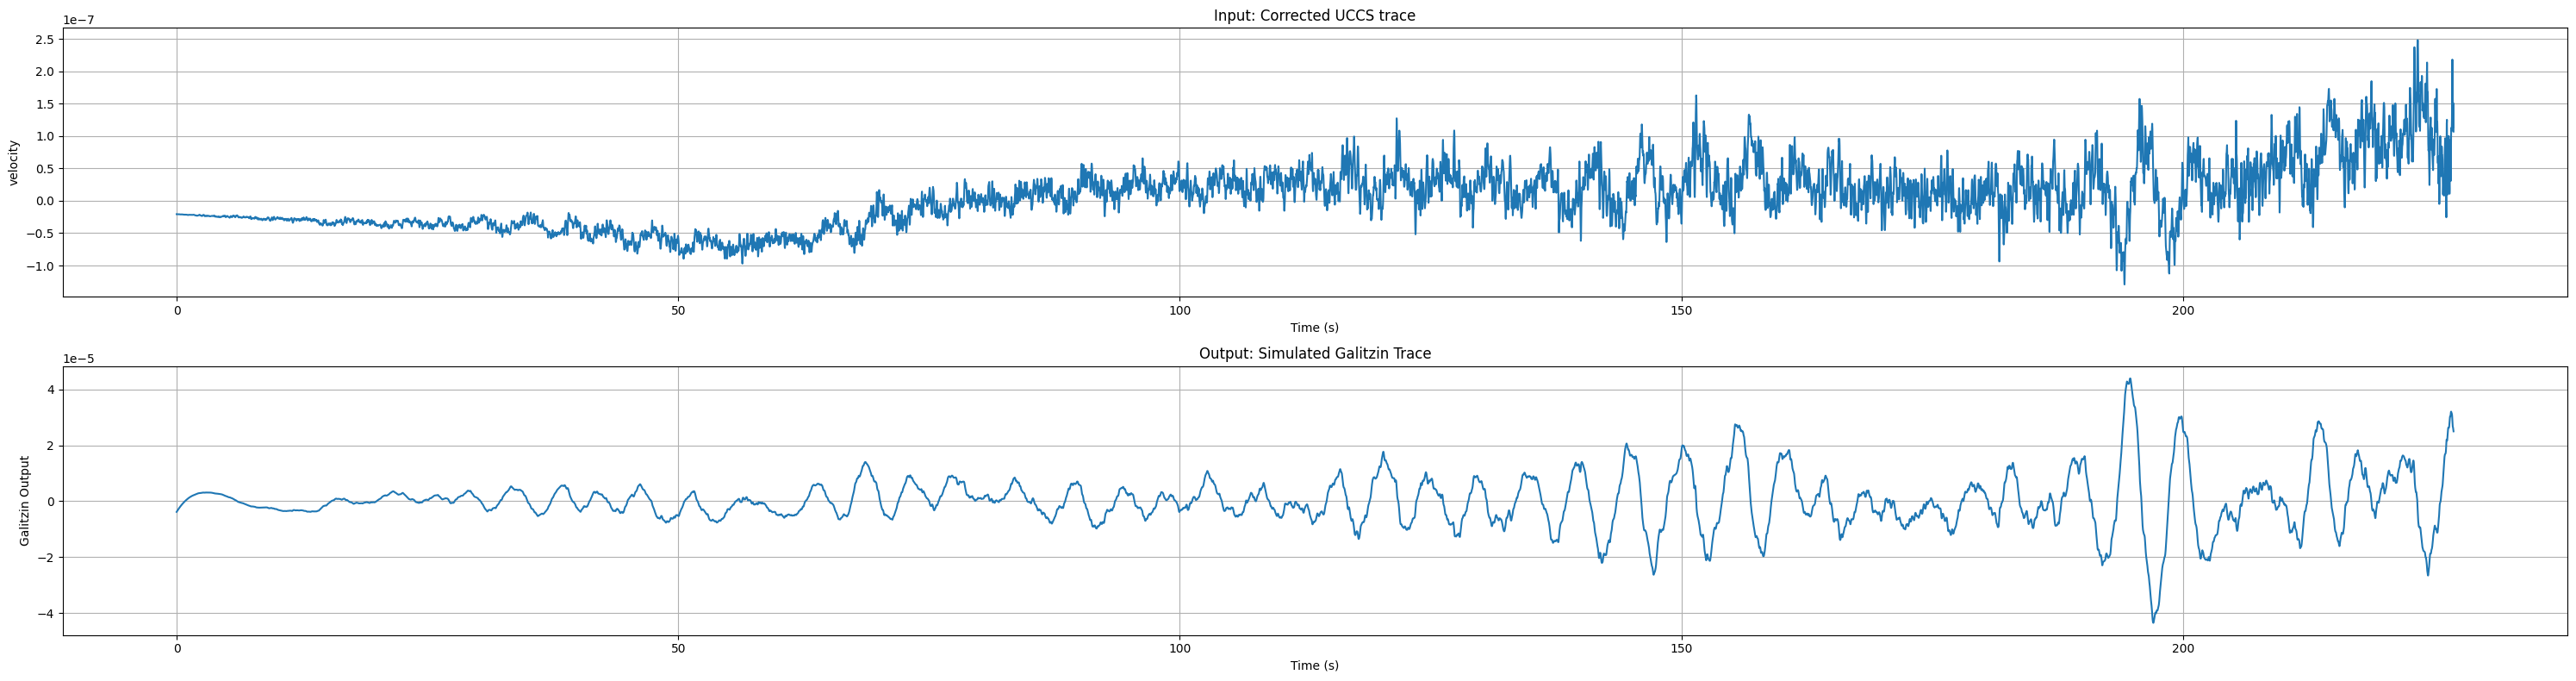

In [ ]:
# Plot the difference
xmin = 0
xmax = xmin + len(tr.times()) / tr.stats.sampling_rate
# Plot
plt.figure(figsize=(30, 8))

plt.subplot(211)
plt.plot(tr.times(), tr.data)
plt.title('Input: Corrected UCCS trace')
plt.xlabel('Time (s)')
plt.ylabel('velocity')
plt.grid(True)
plt.xlim(xmin,xmax)
plt.subplot(212)
plt.plot(tr.times(), galitzin_trace)
plt.title('Output: Simulated Galitzin Trace')
plt.xlabel('Time (s)')
plt.ylabel('Galitzin Output')
plt.grid(True)
plt.xlim(xmin,xmax)
plt.tight_layout()
plt.show()

In [13]:
import cv2
import os

def generate_seismogram_raster(signals,
                                width=1000, height=315, line_thickness=5, noise_level=0.1,
                                l_margin=0, r_margin=0, t_margin=0, b_margin=0, 
                                overlap_percentage=0.2, color_flag=False,
                                filepaths_image=None, filepaths_npy=None):
        """
        Generate a raster-style artificial old paper seismogram from multiple given signals.

        Args:
            signals (np.ndarray): 3D numpy arrays containing the seismic signals, shape (N_images, N_traces, N).
            width (int): Width of the generated seismogram image (in pixels).
            height (int): Height of the generated seismogram image (in pixels).
            line_thickness (int): Thickness of the seismic traces (in pixels).
            noise_level (float): Amount of noise to add to the signal.
            l_margin, r_margin, t_margin, b_margin (int): Margins around the image.
            overlap_percentage (float): Percentage of overlap between consecutive traces.
            color_flag (bool): If True, different colors are used for each signal.
            filepath_image, filepath_npy (str): Path to save the generated image, numpy array of ground truth.
        """      
        N_images, N_traces, N = signals.shape

        # Initialize background
        background_color = 235

        # Compute available height and max amplitude
        available_height = height - t_margin - b_margin
        max_amplitude = (available_height / N_traces) / (1 - overlap_percentage)

        # Precompute vertical offsets
        vertical_offsets = np.linspace(t_margin + max_amplitude / 2, height - b_margin - max_amplitude / 2, N_traces)

        # Precompute horizontal offset
        horizontal_offsets = l_margin
        available_width = width - l_margin - r_margin

        # Generate color palette efficiently
        if color_flag:
            cmap = plt.get_cmap("tab20")
            color_palette = (np.array([cmap(i)[:3] for i in range(N_traces)]) * 255).astype(int)
        else:
            color_palette = [(0, 0, 0)] * N_traces  # Default to black

        for i in range(N_images): 
            background = np.full((height, width), background_color, dtype=np.uint8)

            # Prepare ground truth storage
            GTs = np.zeros((N_traces, background.shape[1]))
            for j in range(N_traces):
                signal = signals[i, j]
                # Normalize and scale signal
                signal_mean = np.mean(signal)
                signal_max = np.max(np.abs(signal))
                signal = (signal - signal_mean) / signal_max
                scaled_signal = (max_amplitude / 2) * signal + vertical_offsets[N_traces - 1 - j]

                # Generate coordinates efficiently
                x_coords = np.linspace(0, available_width - 1, background.shape[1]).astype(np.int32) + horizontal_offsets
                y_coords = np.clip(scaled_signal.astype(np.int32), 0, height - 1)  # Ensure bounds

                # Crop x_coords and y_coords to background.shape[1]
                y_coords = y_coords[:background.shape[1]]
                GTs[j] = height - y_coords

                # Convert to OpenCV polyline format
                pts = np.column_stack((x_coords, height - y_coords))

                # Draw waveform using polylines for efficiency
                color = 0
                cv2.polylines(background, [pts], isClosed=False, color=color, thickness=line_thickness)

            # Add noise
            # noise = np.random.normal(0, noise_level * 255, background.shape).astype(np.int32)
            # final_image = np.clip(background + noise, 0, 255).astype(np.uint8)
            final_image = background

            # save analysis
            # Ensure the directory exists
            os.makedirs(os.path.dirname(filepaths_image[i]), exist_ok=True)
            os.makedirs(os.path.dirname(filepaths_npy[i]), exist_ok=True)

            # save the image in pdf format
            plt.imsave(filepaths_image[i], final_image, dpi=300, cmap='gray')

            # save the image in npy format
            np.save(filepaths_npy[i], GTs)

In [14]:
signal = galitzin_trace

# Parameters
N = 11350
N_images = 20
N_signals = 2 # USER

# Compute maximum starting index
max_start = len(signal) - N

# Preallocate signals array
signals = np.zeros((N_images, N_signals, N))

# Fill the array with randomly selected subsignals
for i in range(N_images):
    for j in range(N_signals):
        start = np.random.randint(0, max_start + 1)
        signals[i, j] = signal[start:start + N]

directory_data = r"data_{}_traces\GT_Galitzine".format(N_signals)

for i, overlap in enumerate(np.linspace(0.0, 0.5, 10)):  # Different overlap levels
    filepaths_image = [
        os.path.join(directory_data, f"overlap_{overlap:.2f}", "signals", f"image_{img_idx}.jpg")
        for img_idx in range(N_images)
    ]

    filepaths_npy = [
        os.path.join(directory_data, f"overlap_{overlap:.2f}", "ground_truths", f"GT_{img_idx}.npy")
        for img_idx in range(N_images)
    ]

    generate_seismogram_raster(signals, overlap_percentage=overlap, color_flag=False,
                               filepaths_image=filepaths_image, filepaths_npy=filepaths_npy)